**классификатор текстов LSTM**

Евгений Борисов <esborisov@sevsu.ru>

https://habr.com/ru/company/dca/blog/274027/    
http://help.sentiment140.com/for-students/   
http://study.mokoron.com  

## Библиотеки

In [1]:
import numpy as np
import numpy.random as rng

import pandas as pd
pd.options.display.max_colwidth = 200  
import re
# import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
# from torchviz import make_dot

In [3]:
tqdm.pandas()

In [4]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [5]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [6]:
neg = pd.read_csv('../data/twit/negative.csv.gz',sep=';',header=None)
ppr(neg)
neg.columns = ff

записей: 111 923


In [7]:
pos = pd.read_csv('../data/twit/positive.csv.gz',sep=';')
ppr(pos)
pos.columns = ff

записей: 114 910


In [8]:
data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

записей: 226 833


In [9]:
data.sample(10)

,id,ttext,ttype
62655,416835819560009728,@korchagina_g не знаю не очень хочу( я маленько болею,-1
38580,409886633069404160,@wrong_mary так то) утром это особенно мило) и я тебя),1
102850,411106583498981376,"@AinurArenova я там как NeoJet числюсь :))) надеюсь, Вам понравится :)",1
66784,410386999544410112,RT @Daria_Suvorova: @procop_miy с Днём рождения тебя),1
74108,418621500464574464,"RT @sanja_ti_907239: я его любила(((он мне отвечал взаимностью..,а всё оказалось разводкой(больно(",-1
88715,410824778866753536,"Ну и не без говна конечно же, учитесь хотя бы достойно себя вести после всего этого))",1
43697,414305516488097792,"Чего-то Killing Floor снова упал. Вчера из-за того, что я альтабался, а теперь просто так, на последнем боссе ложится сервер(",-1
68057,410398785916116992,"В Ростове-на-Дону пошел снег, и меня упороло в хющо. Приятного просмотра х) http://t.co/MpnfEpTWP8",1
57988,416128833663016960,"ПОЧЕМУ СОООН, А?! ЧТО ЗА ФИГНЯ! ПЕЧАЛЬКА:(",-1
52633,410055731858391040,скок подписчиков ? 5?азаза — нет) 21 http://t.co/wJypHu4vQI,1


## очистка данных

In [10]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

100%|██████████| 226833/226833 [00:01<00:00, 115324.66it/s]


In [11]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [12]:
data['ttext_clean'] = data['ttext_clean'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 226833/226833 [00:02<00:00, 94894.11it/s] 


In [13]:
data.sample(3)

,id,ttext,ttype,ttext_clean
100979,423514337576517632,@Zarechnevv нисколько. Ебете нам мозги и ебанутыми еще называете! :(,-1,"[zarechnevv, нисколько, ебете, нам, мозги, и, ебанутыми, еще, называете, sadsmile]"
37320,409844161202769920,меня впырило на один хитрый план к Старкону. но надо бы уже начинать тогда ))))) [mercury.],1,"[меня, впырило, на, один, хитрый, план, к, старкону, но, надо, бы, уже, начинать, тогда, happysmile, mercury]"
7120,410007495508512768,"@kapitalova так жалко детишек, когда они кричат :( да, грудью",-1,"[kapitalova, так, жалко, детишек, когда, они, кричат, sadsmile, да, грудью]"


In [14]:
# удаление коротких слов
# data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda t:[w for w in t if len(w)>2])

In [15]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 226 833
записей: 226 833


In [16]:
data.sample(3)

,id,ttext,ttype,ttext_clean
105323,411129154751692801,1 шайба Андрей 2 шайба Егор 3 шайба Миша 4 шайба Антон :* \nМальчики вы умницы!:* \nРебята вы в Молодёжке,1,"[digit, шайба, андрей, digit, шайба, егор, digit, шайба, миша, digit, шайба, антон, kisssmile, мальчики, вы, умницы, kisssmile, ребята, вы, в, молодёжке]"
133330,411442198669193216,RT @gedobowujypa: Интереснота. Интерфакс приводит слова МБХ (,-1,"[rt, gedobowujypa, интереснота, интерфакс, приводит, слова, мбх]"
167053,415393253983535104,"На флаге Мозамбика изображен автомат Калашникова. Плачьте, мозамбикцы:( http://t.co/iTtMxMBCy1",-1,"[на, флаге, мозамбика, изображен, автомат, калашникова, плачьте, мозамбикцы, sadsmile, url]"


## словарь

In [17]:
voc = sorted(set.union(*[ set(s) for s in data['ttext_clean'].values.tolist() ]))
voc = { w:i+1 for i,w in enumerate(voc) }
voc['<pad>']= 0
ppr(voc)

записей: 240 845


In [18]:
voc

{'a': 1,
 'aa': 2,
 'aaa': 3,
 'aaaa': 4,
 'aaaaa': 5,
 'aaaaaaaaaa': 6,
 'aaaaaaaaaaart': 7,
 'aaaaaahhhhhhwow': 8,
 'aaaasyaaa': 9,
 'aaaats': 10,
 'aaahaahaaaah': 11,
 'aaaidar': 12,
 'aaaiguuul': 13,
 'aaakristya': 14,
 'aaalsusha': 15,
 'aaarrrrrrrr': 16,
 'aaaw': 17,
 'aaburnashov': 18,
 'aafrolova': 19,
 'aakarimova': 20,
 'aakellah': 21,
 'aakuzichev': 22,
 'aaleksandra': 23,
 'aaleksandrowna': 24,
 'aalello': 25,
 'aalexithymiaa': 26,
 'aalistok': 27,
 'aalive': 28,
 'aallanavaz': 29,
 'aalove': 30,
 'aammmmmmmm': 31,
 'aamnastya': 32,
 'aamooorr': 33,
 'aamy': 34,
 'aanaokay': 35,
 'aanastasiaden': 36,
 'aandrushkas': 37,
 'aanechaev': 38,
 'aanjkaa': 39,
 'aanneeeet': 40,
 'aannybarry': 41,
 'aanvarova': 42,
 'aanxaa': 43,
 'aapogodina': 44,
 'aarn': 45,
 'aaronpaul': 46,
 'aasexuality': 47,
 'aashirokov': 48,
 'aasokol': 49,
 'aasviridova': 50,
 'aatemkin': 51,
 'aavsasha': 52,
 'aavst': 53,
 'aaw': 54,
 'aaww': 55,
 'aaxaxaax': 56,
 'aayra': 57,
 'aazbaeva': 58,
 'ab': 59,

## строим датасет

In [19]:
# заменяем слова на номера в словаре
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ voc[w] for w in t] )

100%|██████████| 226833/226833 [00:01<00:00, 226158.89it/s]


In [20]:
data[['ttext','ttext_clean','code']].sample(3)

,ttext,ttext_clean,code
22466,"RT @the_unknown_2c: Так, математика вона така! ОСОБЛИВО ВИШКА, ну @LucyAndrosyuk знає!) http://t.co/xR7LzJ9Z3T","[rt, the, unknown, так, математика, вона, така, особливо, вишка, ну, lucyandrosyuk, знає, url]","[51329, 59111, 61548, 212291, 138468, 88634, 212293, 159987, 86869, 153539, 35175, 116942, 61701]"
156868,кому мне еще без собаки написать?\nмоя линта тихая такая дажи никого найти нимогу(,"[кому, мне, еще, без, собаки, написать, моя, линта, тихая, такая, дажи, никого, найти, нимогу]","[127161, 141403, 107878, 76893, 203921, 146682, 142958, 134223, 215083, 212302, 98957, 152101, 145833, 152210]"
40423,"Рассталась с парнем, и тут сразу начали писать куча парней:) я оказывается еще не так плоха:)","[рассталась, с, парнем, и, тут, сразу, начали, писать, куча, парней, happysmile, я, оказывается, еще, не, так, плоха, happysmile]","[191545, 196027, 164822, 117479, 218127, 207461, 148420, 168965, 131759, 164821, 22101, 239022, 157611, 107878, 148731, 212291, 170033, 22101]"


In [21]:
# оценка длины последовательностей
data['code'].str.len().describe().astype(int)

count    226833
mean         13
std           5
min           1
25%           9
50%          12
75%          16
max          42
Name: code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

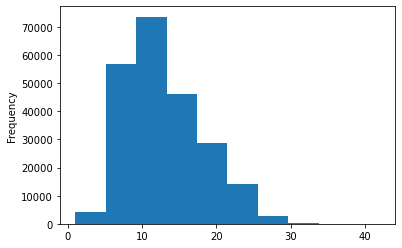

In [22]:
data['code'].str.len().plot.hist()

In [23]:
# максимальная длинна
code_max_len = data['code'].str.len().max()
code_max_len

42

In [24]:
# выравниваем длину последовательностей
z = [0]*code_max_len # дополняем нулями короткие последовательности
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

100%|██████████| 226833/226833 [00:00<00:00, 307156.52it/s]


In [25]:
data['code'].str.len().describe().astype(int)

count    226833
mean         42
std           0
min          42
25%          42
50%          42
75%          42
max          42
Name: code, dtype: int64

---

In [26]:
# собираем матрицу датасета
x = np.stack( data['code'].values).astype(int)

# для повышения эффективности работы рекуррентной модели
# переворачиваем последовательности, 
# код первого слова в конце, 
# нули дополнения в начале
x = np.flip(x,axis=1)

x.shape

(226833, 42)

In [27]:
# метка класса {0,1}
n_classes = 2 # количество классов
y = (data['ttype'].values+1) // 2
y.shape

(226833,)

In [28]:
max_word = x.max() # максимальный номер слова
seq_len = x.shape[1] # длина последовательности

max_word, seq_len

(240844, 42)

In [29]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=.4 )
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((136099, 42), (136099,), (90734, 42), (90734,))

In [30]:
# количество позитивных примеров в train и test наборах
y_train.sum(axis=0),y_test.sum(axis=0),

(68915, 45995)

----

In [31]:
# def get_batch(x,y,batch_size=512):
#     n = x.shape[0] # количество примеров
#     pt = int(np.ceil(n/batch_size)) # количество батчей
    
#     # случайным образом мешаем примеры и режем на батчи
#     ii = rng.permutation(n)
#     xr,yr = np.array_split(x[ii,:],pt), np.array_split(y[ii],pt)
    
#     for i in range(pt): # генератор выдаёт батчи
#         yield i,xr[i],yr[i]

In [32]:
# batches = get_batch(x_train,y_train,batch_size=512)    
# for i,xb,yb in batches: 
#     print(i,xb.shape)

---

In [33]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# batch_size=1024
batch_size=2048


train_ds = TensorDataset( torch.tensor(x_train), torch.tensor(y_train) )
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [34]:
# for xb, yb in train_dl: 
#     print(xb.shape,yb.shape)
#     break
#
## > torch.Size([1024, 32]) torch.Size([1024])

## строим модель

In [35]:
embedding_dim = 128 # размер выхода эмбединга
hidden_dim = 64 # размер рекуррентного слоя

In [36]:
class Model(nn.Module):
    def __init__(self, 
                 num_embeddings=max_word+1, # размер входа эмбединга (длина OHE)
                 emb_dim=embedding_dim, # размер выхода эмбединга
                 hid_dim=hidden_dim, # размер рекуррентного слоя
                 output_dim=n_classes # размер выхода
                ):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim) 
        self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=True) # рекуррентный слой
        self.linear = nn.Linear(hid_dim, output_dim) # выходной (линейный) слой
        self.sftm = nn.Softmax(dim=1)

    def forward(self,x):
        out = self.emb(x)
        _, (hidden, _) = self.rnn(out) # обрабатываем входную последовательность
        hidden = hidden.squeeze(0) # прекомпоновка тензора, сокращаем размерность
        out = self.linear(hidden) # считаем выход сети
        out = self.sftm(out)
        return out 

In [37]:
model = Model()
model

Model(
  (emb): Embedding(240845, 128)
  (rnn): LSTM(128, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
  (sftm): Softmax(dim=1)
)

In [38]:
# z = torch.zeros( size=(1,seq_len), dtype=torch.int, requires_grad=False)
# out = model(z)
# make_dot( out, params=dict(list(model.named_parameters())), ) #show_attrs=True )  
# # .render("rnn_torchviz", format="png")

## обучаем модель

In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [40]:
model = model.to(device)

In [41]:
loss_function =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [42]:
%%time

epochs = 32
hist = []
for i in range(epochs):

    for j,(xb,yb) in enumerate(train_dl):
        xt,yt = xb.to(device), yb.to(device)
        optimizer.zero_grad() # обнуляем значения градиента
        out = model(xt) # вычисляем выход, прямой проход
        loss = loss_function(out,yt) # вычисляем значение потери
        loss.backward() # вычисляем значения градиента потери, обратный проход
        optimizer.step() # изменяем значения весов модели
        hist.append( loss.item() ) # сохраняем текущее значение потери
        
    print(f'{i:3} : {loss.item():.4f}')


  0 : 0.4201
  1 : 0.3916
  2 : 0.3538
  3 : 0.3506
  4 : 0.3485
  5 : 0.3327
  6 : 0.3395
  7 : 0.3274
  8 : 0.3305
  9 : 0.3264
 10 : 0.3276
 11 : 0.3336
 12 : 0.3355
 13 : 0.3312
 14 : 0.3291
 15 : 0.3333
 16 : 0.3253
 17 : 0.3305
 18 : 0.3264
 19 : 0.3274
 20 : 0.3253
 21 : 0.3221
 22 : 0.3259
 23 : 0.3292
 24 : 0.3287
 25 : 0.3305
 26 : 0.3172
 27 : 0.3263
 28 : 0.3282
 29 : 0.3277
 30 : 0.3198
 31 : 0.3287
CPU times: user 1min 51s, sys: 120 ms, total: 1min 51s
Wall time: 1min 50s


In [43]:
torch.cuda.empty_cache()

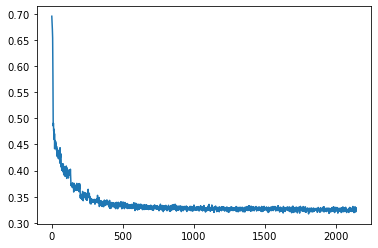

In [44]:
# изменение значения потери в процессе обучения
plt.plot(hist)

## тест

In [45]:
model = model.to('cpu')

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [47]:
xt = torch.tensor(x_test)
out = model(xt)
scores = out.detach().numpy()
y_pred = np.argmax( scores ,axis=1)

In [48]:
accuracy_score(y_test, y_pred)

0.8949566865783499

In [49]:
print(classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

           0       0.88      0.91      0.90     44739
           1       0.91      0.88      0.89     45995

    accuracy                           0.89     90734
   macro avg       0.90      0.90      0.89     90734
weighted avg       0.90      0.89      0.89     90734



----

In [50]:
# from matplotlib import pyplot as plt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Dense

# embedding_size = 64

# model = Sequential()
# model.add(Embedding( input_dim = max_word+1, output_dim = embedding_size, input_length = seq_len,))
# model.add(LSTM(32))
# model.add(Dense(n_classes, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# hist = model.fit(x_train,y_train, batch_size=1024, epochs=9, validation_split=.3)

# model.evaluate( x_test ,y_test )

# k = hist.history.keys()
# w,h = 6,4
# fig,ax = plt.subplots(1,len(k),figsize=(w*len(k),h))
# for i,n in enumerate(k):
#     ax[i].plot(hist.history[n],label=n)
#     ax[i].grid(True)
#     ax[i].legend()
#     ax[i].set_ylim([-.1,1.1])